# The Data

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.
https://www.kaggle.com/datasets/msambare/fer2013?resource=download

# 2. Initial EDA

### Importing Packages

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from skimage import io
import random

In [5]:
!pwd

/Users/ivan.miller/Documents/study/ccny/22Spring_ML/final_project/facial-expression-recognition/notebooks


In [5]:
# '/Users/ivan.miller/Documents/study/ccny/22Spring_ML/final_project/project_data/test'
train_path = '../../project_data/train/' # added the last forward slash
test_path = '../../project_data/test/' # added the last forward slash

# create a dictionary with each emotion encoded as integer
# emotions = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}
# create a dictionary with values as keys to lookup original labels
# label_lookup  = {y: x for x, y in emotions.items()} 

#### Exploring the folder contents

In [6]:
# dir_paths = [] # paths to files
# dir_names = [] # flattened images
# files = [] # integers as labels 
# for dir_path, dir_name, file_names in os.walk(train_path, topdown=False):
#     dir_paths.append(dir_path)
#     dir_names.append(dir_name)
#     for filename in file_names:
#         files.append(filename)

In [7]:
# dir_paths

In [8]:
# dir_names

In [9]:
# files[:3]

### Loading the data

In [10]:
def preprocess(path_to_folder):
    
    '''
    Takes path to a directory with images (train or test) as input
    Returns three lists:
    1. Full paths to image files
    2. Images as flattened arrays
    3. String labels for each image
    '''
    
    files = [] # paths to files
    images = [] # flattened images
    labels = [] # integers as labels 

    for dir_path, dir_name, file_names in os.walk(path_to_folder, topdown=False):
        label = dir_path.replace(path_to_folder,'') # taking a label out of path
        if label != '':
            for filename in file_names:
                file_path = os.path.join(dir_path, filename) # creaitng a full path for file
                img = io.imread(file_path) # reading the image from the path
                img_array = np.array(img).flatten() # creating an array and flattening

                files.append(file_path) # append file path
                images.append(img_array) # append flattened array
                labels.append(label) # append label as a string
#                 labels.append(emotions[label]) # append label as an integer
    
    # print out lengths of each list before returning the results
    print(f'Number of files: {len(files)}')
    print(f'Number of images: {len(images)}')
    print(f'Number of labels: {len(labels)}')
    return files, images, labels

In [11]:
# Creating the lists for files arrays and labels of train data
train_files, train_images, train_labels = preprocess(train_path)

Number of files: 28709
Number of images: 28709
Number of labels: 28709


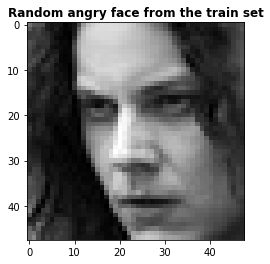

In [12]:
# Sanity check using a random image from the train set
f = random.randint(1,len(train_files))
img = io.imread(train_files[f])

plt.imshow(img, cmap='gray')
plt.title(f'Random {train_labels[f]} face from the train set', fontweight = 'bold')
plt.show()

# print(f'Label: {label_lookup[train_labels[f]]}')

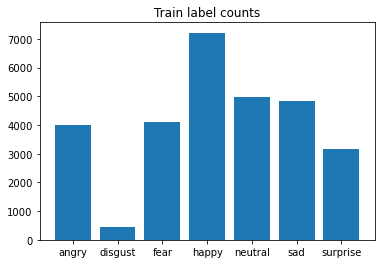

In [13]:
#Count the number of occurences in the train set
label, counts = np.unique(train_labels, return_counts = True)

plt.bar(label, counts )
plt.title('Train label counts')
plt.show()

In [14]:
# Creating the lists for files arrays and labels of train data
test_files, test_images, test_labels = preprocess(test_path)

Number of files: 7178
Number of images: 7178
Number of labels: 7178


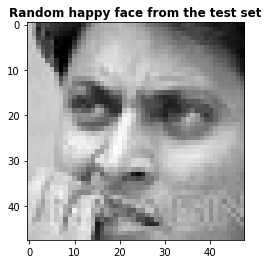

In [15]:
# Sanity check using a random image from the test set
f = random.randint(1,len(test_files))
img = io.imread(test_files[f])

plt.imshow(img, cmap='gray')
plt.title(f'Random {train_labels[f]} face from the test set', fontweight = 'bold')
plt.show()

# print(f'Label: {label_lookup[train_labels[f]]}')

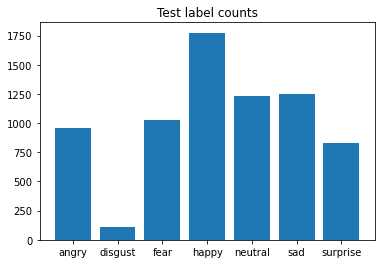

In [16]:
#Count the number of occurences in the train set
label, counts = np.unique(test_labels, return_counts = True)

plt.bar(label, counts )
plt.title('Test label counts')
plt.show()

## Keras

## TensorFlow

In [30]:
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

# from PIL import Image

In [18]:
print(tf.__version__)

2.8.0


In [19]:
# checking image size
f = random.randint(1,len(test_files))
img = io.imread(test_files[f])
print(img.shape)
img_size = img.shape[0]
img_size

(48, 48)


48

In [20]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(
                                # rotation_range = 180,
                                 width_shift_range = 0.1, 
                                 height_shift_range = 0.1, 
                                 horizontal_flip = True,# Boolean. Randomly flip inputs horizontally.
                                 rescale = 1./255, # rescaling factor.
                                 zoom_range = 0.1, # Range for random zoom
                                 validation_split = 0.3 # Fraction of images reserved for validation
                                )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.3)

In [21]:
"""
Apply above transformations to the train/test images
"""
train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_path,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 20099 images belonging to 7 classes.
Found 2151 images belonging to 7 classes.


### Creating a Model

In [23]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [24]:
epochs = 60
batch_size = 64

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 128)      

In [27]:
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/60


2022-05-01 12:34:16.246086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-01 12:34:16.773924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


315/315 [==============================] - ETA: 0s - loss: 9.1996 - accuracy: 0.2011

2022-05-01 12:35:05.536622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


315/315 [==============================] - 51s 138ms/step - loss: 9.1996 - accuracy: 0.2011 - val_loss: 8.6556 - val_accuracy: 0.1358
Epoch 2/60
315/315 [==============================] - 41s 130ms/step - loss: 8.4009 - accuracy: 0.2365 - val_loss: 8.0226 - val_accuracy: 0.2538
Epoch 3/60
315/315 [==============================] - 41s 131ms/step - loss: 7.7068 - accuracy: 0.2592 - val_loss: 7.2637 - val_accuracy: 0.2817
Epoch 4/60
315/315 [==============================] - 41s 132ms/step - loss: 6.9820 - accuracy: 0.2785 - val_loss: 6.5595 - val_accuracy: 0.3059
Epoch 5/60
315/315 [==============================] - 41s 132ms/step - loss: 6.2791 - accuracy: 0.3007 - val_loss: 5.8503 - val_accuracy: 0.3264
Epoch 6/60
315/315 [==============================] - 43s 137ms/step - loss: 5.5841 - accuracy: 0.3228 - val_loss: 5.2773 - val_accuracy: 0.3226
Epoch 7/60
315/315 [==============================] - 42s 133ms/step - loss: 4.9350 - accuracy: 0.3526 - val_loss: 4.5529 - val_accuracy: 0.3

#### Plotting Accuracy Scores

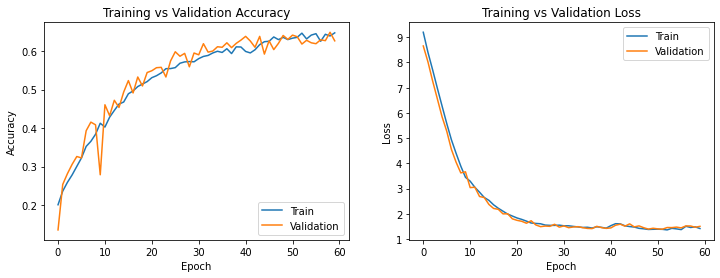

In [29]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='lower right')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()